
## PROBLEM STATEMENT AND REQUIREMENT

- BoomBikes aspires to understand the demand for shared bikes
- To understand the factors affecting the demand for these shared bikes
- The company wants to know:
    - Which variables are significant in predicting the demand for shared bikes.
    - How well those variables describe the bike demands <br/> <br/>

- Requirement : To model the demand for shared bikes with the available independent variables. <br/> <br/>

Ref : https://learn.upgrad.com/course/4622/segment/27474/233892/714374/3606119


# DATA UNDERSTANDING, PREPARATION and EDA

In [166]:
# Importing required modules for this task

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import calendar

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as mp

In [167]:
# Suppressing warnings from the library
warnings.filterwarnings('ignore')

## DATA SOURCING

In [168]:
# Reading the data from the day.csv file provided for the assignment
bike = pd.read_csv("day.csv")

In [169]:
# Understanding the dimension of the data
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [170]:
bike.shape

(730, 16)

The CSV file has 730 rows of data with 16 columns (attributes/ indicators)

In [171]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## DATA QUALITY CHECK AND MAPPING

In [172]:
print(bike.notnull().sum())

instant       730
dteday        730
season        730
yr            730
mnth          730
holiday       730
weekday       730
workingday    730
weathersit    730
temp          730
atemp         730
hum           730
windspeed     730
casual        730
registered    730
cnt           730
dtype: int64


Obs 2 : None of the columns have missing value, it is good 

In [173]:
print(bike.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


#### Checking for duplicate rows

In [174]:
bike_duplicate = bike[bike.duplicated()]
print(bike_duplicate)

Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt]
Index: []


Obs : No duplicate rows, it is good

#### Columns to be dropped 

-   instant is like an id which is not required since we are not going to focus on any particular row
-   dteday - since we have year and month so we can drop this column
-   casual and registered - if we add both we get the total cnt so we can drop these columns


In [175]:
'''
columns to be dropped - 

1. instant is like an id which is not required since we are not going to focus on any particular row
2. dteday - since we have year and month so we can drop this column
3. casual and registered - if we add both we get the total cnt so we can drop these columns
'''
drop_columns = ['instant','dteday', 'casual','registered']
for i in drop_columns:
    bike.drop(i, axis=1, inplace=True)

In [176]:
bike.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [177]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


Now the bike dataframe has 12 indicators to proceed further for analysis


#### Mapping Categorical variables as per the dictionary

In [178]:
def weather_map(x):
    dictionary = {1:'Clear', 2:'Mist', 3:'LightSnow', 4:'HeavyRain'}
    return dictionary[x]

# Defining the season map function
def season_map(x):
    dictionary = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
    return dictionary[x]

#Below commented code can be used for avoiding hardcoded weekdays
'''
day_dictionary = {}
for i in range(7):
    day_dictionary[i] = calendar.day_name[i-1]
'''

# Defining the day map function
def day_map(x):
    #global day_dictionary
    day_dictionary = {0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'}
    return day_dictionary[x]


#Below commented code can be used for avoiding hardcoded months
'''
month_dictionary = {}
for i in range(1, 13):
    month_dictionary[i] = calendar.month_name[i]
'''
#Defining month map function
def month_map(x):
    #global month_dictionary
    #This is to take only first 3 characters for easy representation
    month_dictionary = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    return month_dictionary[x]

def year_map(x):
    year_dictionary = {0: '2018', 1:'2019'}
    return year_dictionary[x]


In [179]:
# Applying the function to the housing list
'''
bike['weathersit'] = bike['weathersit'].apply(weather_map)
bike['season'] = bike['season'].apply(season_map)
bike['weekday'] = bike['weekday'].apply(day_map)
bike['mnth'] = bike['mnth'].apply(month_map)
bike['yr'] = bike['yr'].apply(year_map)
'''
indicators = ['season', 'mnth', 'weekday','weathersit', 'yr']
maps = [season_map, month_map, day_map, weather_map, year_map]
for i in range(len(indicators)):
    bike[indicators[i]] = bike[indicators[i]].apply(maps[i])

In [180]:
bike

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Sat,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Sun,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,2019,Dec,0,Thu,1,Mist,10.420847,11.33210,65.2917,23.458911,2114
726,spring,2019,Dec,0,Fri,1,Mist,10.386653,12.75230,59.0000,10.416557,3095
727,spring,2019,Dec,0,Sat,0,Mist,10.386653,12.12000,75.2917,8.333661,1341
728,spring,2019,Dec,0,Sun,0,Clear,10.489153,11.58500,48.3333,23.500518,1796


## EXPLORATORY DATA ANALYSIS

### Identifying the numeric variables

In [181]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    object 
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 68.6+ KB


In [182]:
# To get the float columns
float_columns = bike.select_dtypes(include=float)

# To get the int columns
int_columns = bike.select_dtypes(include=int)

# Combining both int and float numeric columns
numeric_columns = list(float_columns.columns) + list(int_columns.columns)


# There are lots of categorical variables will come under int, so we need to identify those variables by applying the logic, 
# the logic is if the column has only o and 1 then it is categorical so that column has to be removed from the numeric column list

categorial_variables_in_numeric_columns = []
for i in numeric_columns:
    x = bike[i].nunique()
    if x == 2:
        x_set = set(bike[i].tolist())
        if 0 in x_set and 1 in x_set:
            categorial_variables_in_numeric_columns.append(i)

for i in categorial_variables_in_numeric_columns:
    numeric_columns.remove(i)

In [183]:
numeric_columns

['temp', 'atemp', 'hum', 'windspeed', 'cnt']

The final numeric columns are ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

### Visualizing numeric indicators via Pair Plot

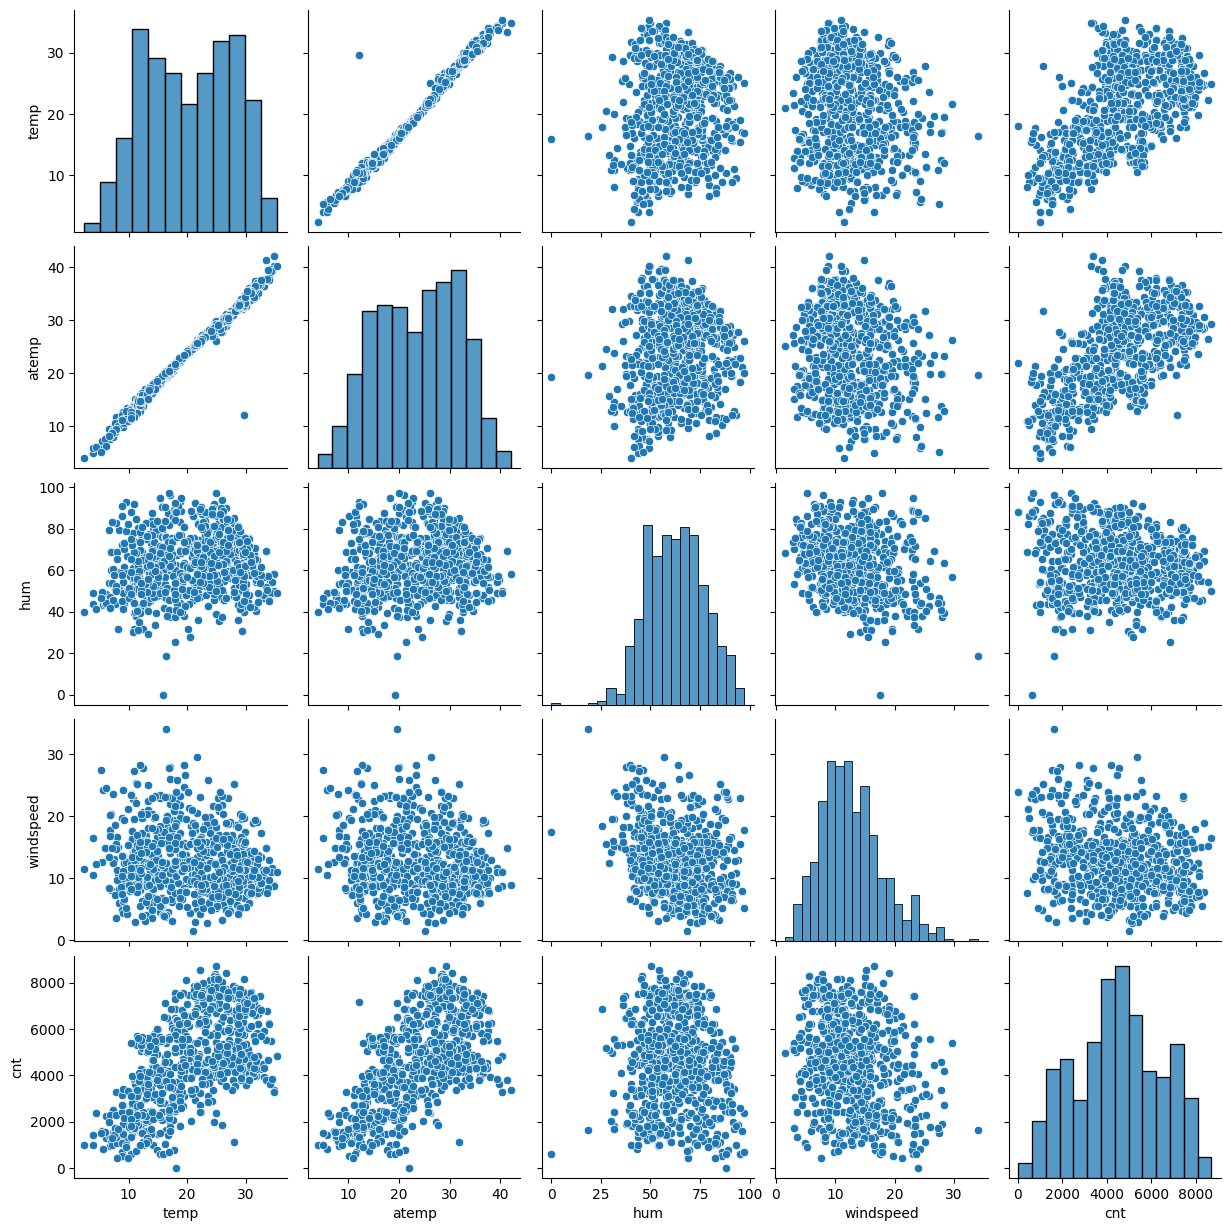

In [184]:
sns.pairplot(bike[numeric_columns])

In [185]:
bike['cnt'].describe()

count     730.000000
mean     4508.006849
std      1936.011647
min        22.000000
25%      3169.750000
50%      4548.500000
75%      5966.000000
max      8714.000000
Name: cnt, dtype: float64

<Axes: xlabel='cnt', ylabel='Density'>

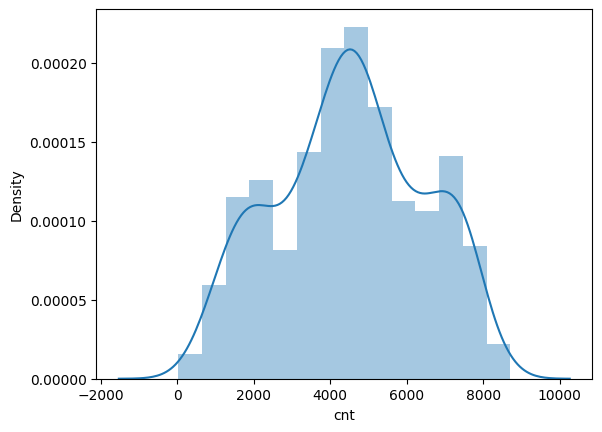

In [186]:
# Target variable in histogram, though it is covered in pair plot, still would like to show as a seperate entity for our reference
sns.distplot(bike['cnt'])

In [255]:
bike['cnt'].corr(bike['temp'])

0.6270440344135154

### Major Observation
- cnt and temp variables have pretty good correlation i.e 62 % positive correlation
- temp and atemp is highly correlated, since both are indicators, atemp should be removed in our subsequent processing steps
- cnt variable i.e Target variable stats
    -   count     730.000000
    -   mean     4508.006849
    -   std      1936.011647
    -   min        22.000000
    -   25%      3169.750000
    -   50%      4548.500000
    -   75%      5966.000000
    -   max      8714.000000

### Visualizing categorical variables, Variate Analysis

In [188]:
bike

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Sat,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Sun,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,2019,Dec,0,Thu,1,Mist,10.420847,11.33210,65.2917,23.458911,2114
726,spring,2019,Dec,0,Fri,1,Mist,10.386653,12.75230,59.0000,10.416557,3095
727,spring,2019,Dec,0,Sat,0,Mist,10.386653,12.12000,75.2917,8.333661,1341
728,spring,2019,Dec,0,Sun,0,Clear,10.489153,11.58500,48.3333,23.500518,1796


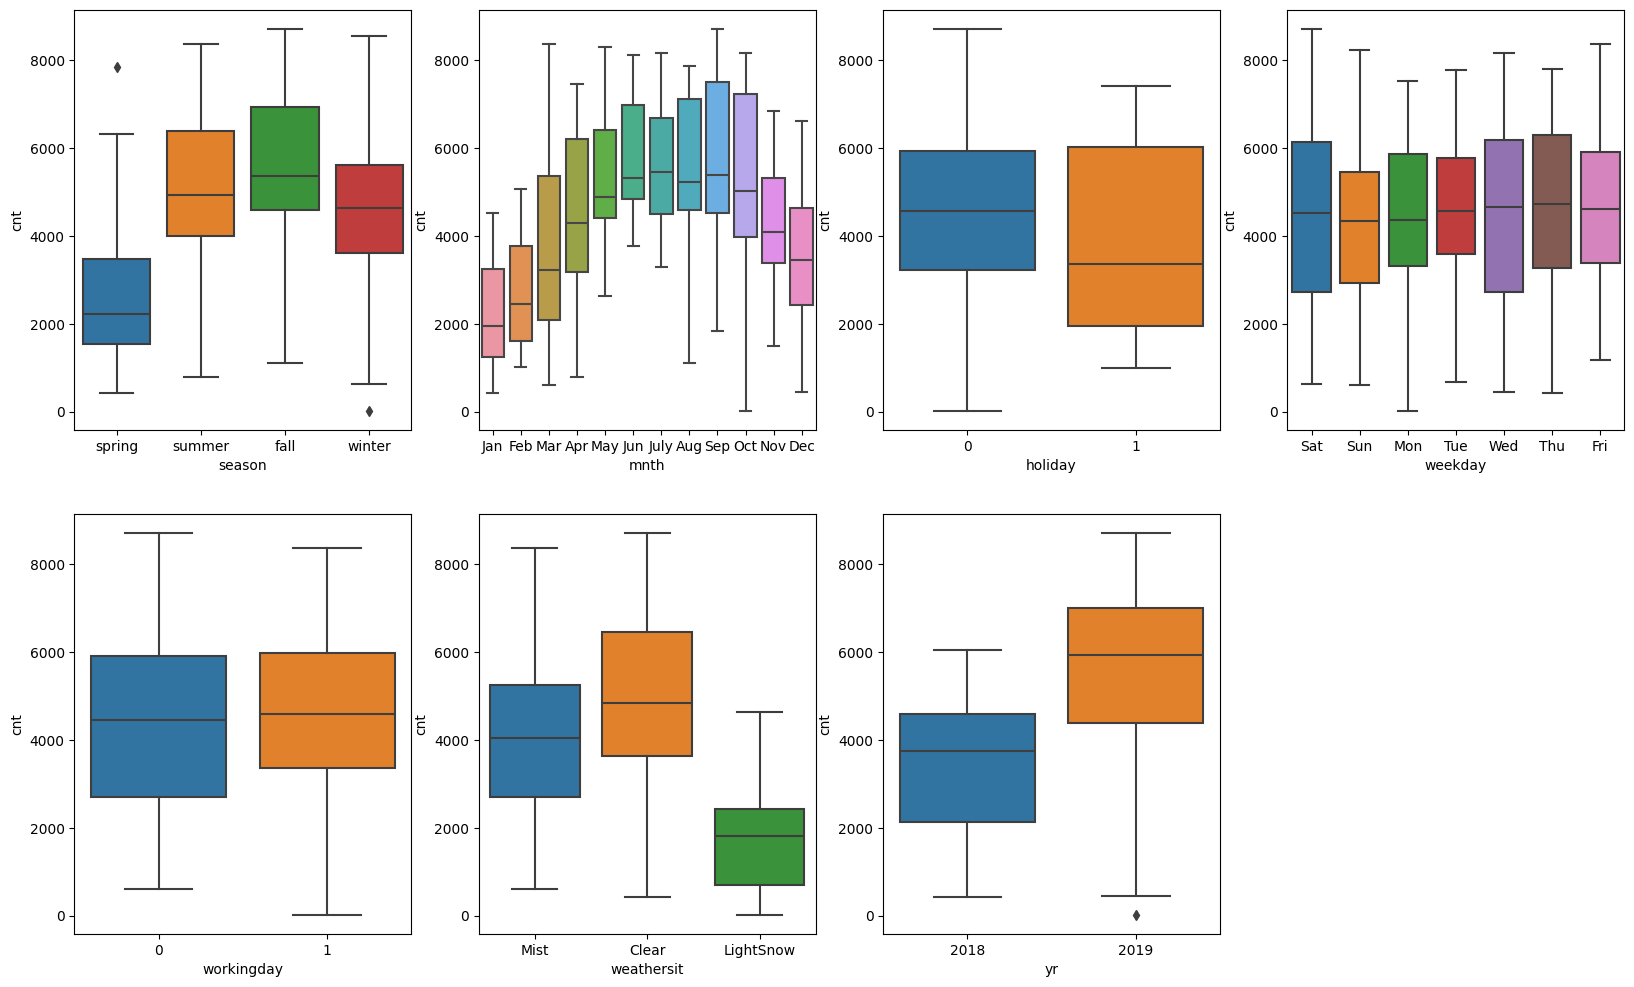

In [189]:
plt.figure(figsize= (20, 12))
cat_variables = ['season','mnth','holiday','weekday', 'workingday', 'weathersit', 'yr']
def draw_box_sub_plot(df, sub_plot_var, cat_variable, target_variable = 'cnt'):
    plt.subplot(2, 4, sub_plot_var)
    sns.boxplot(data = df, x = cat_variable, y = 'cnt')
    
for i in range(len(cat_variables)):
    draw_box_sub_plot(bike, (i+1), cat_variables[i])

##### Observation from the above box plot
Bike Rentals 
- More for the yr 2019 compared to yr i.e 2018
- More for clear/ less cloudy 
- With respect to seasons : Increases from spring to summer to fall and decreases from fall to winter
- With respect to mnths : Increases from jan to jun, there is a dip in july then increase till sep decreases till the year end (dec)
- With respect to days : Saturday, Wednesday and Thursday bit more than other days how ever not much significant to conclude well

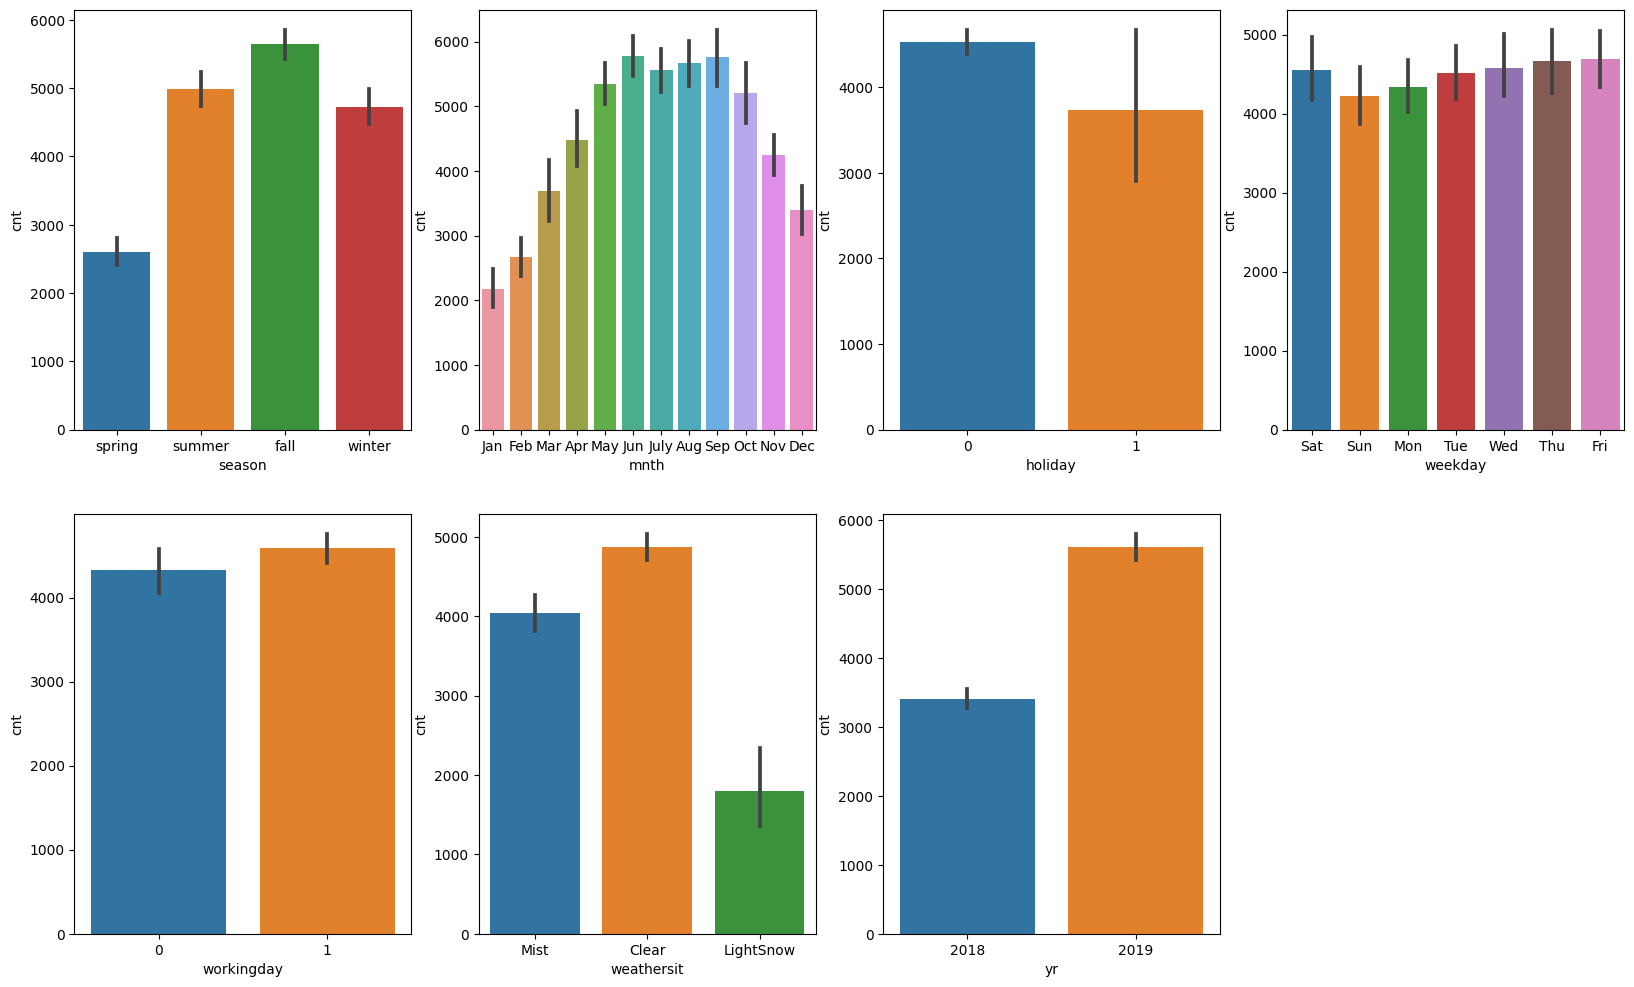

In [190]:
plt.figure(figsize= (20, 12))
cat_variables = ['season','mnth','holiday','weekday', 'workingday', 'weathersit', 'yr']
for i in range(len(cat_variables)):
    plt.subplot(2, 4, (i+1))
    sns.barplot(x = cat_variables[i], y = 'cnt', data=bike)
    

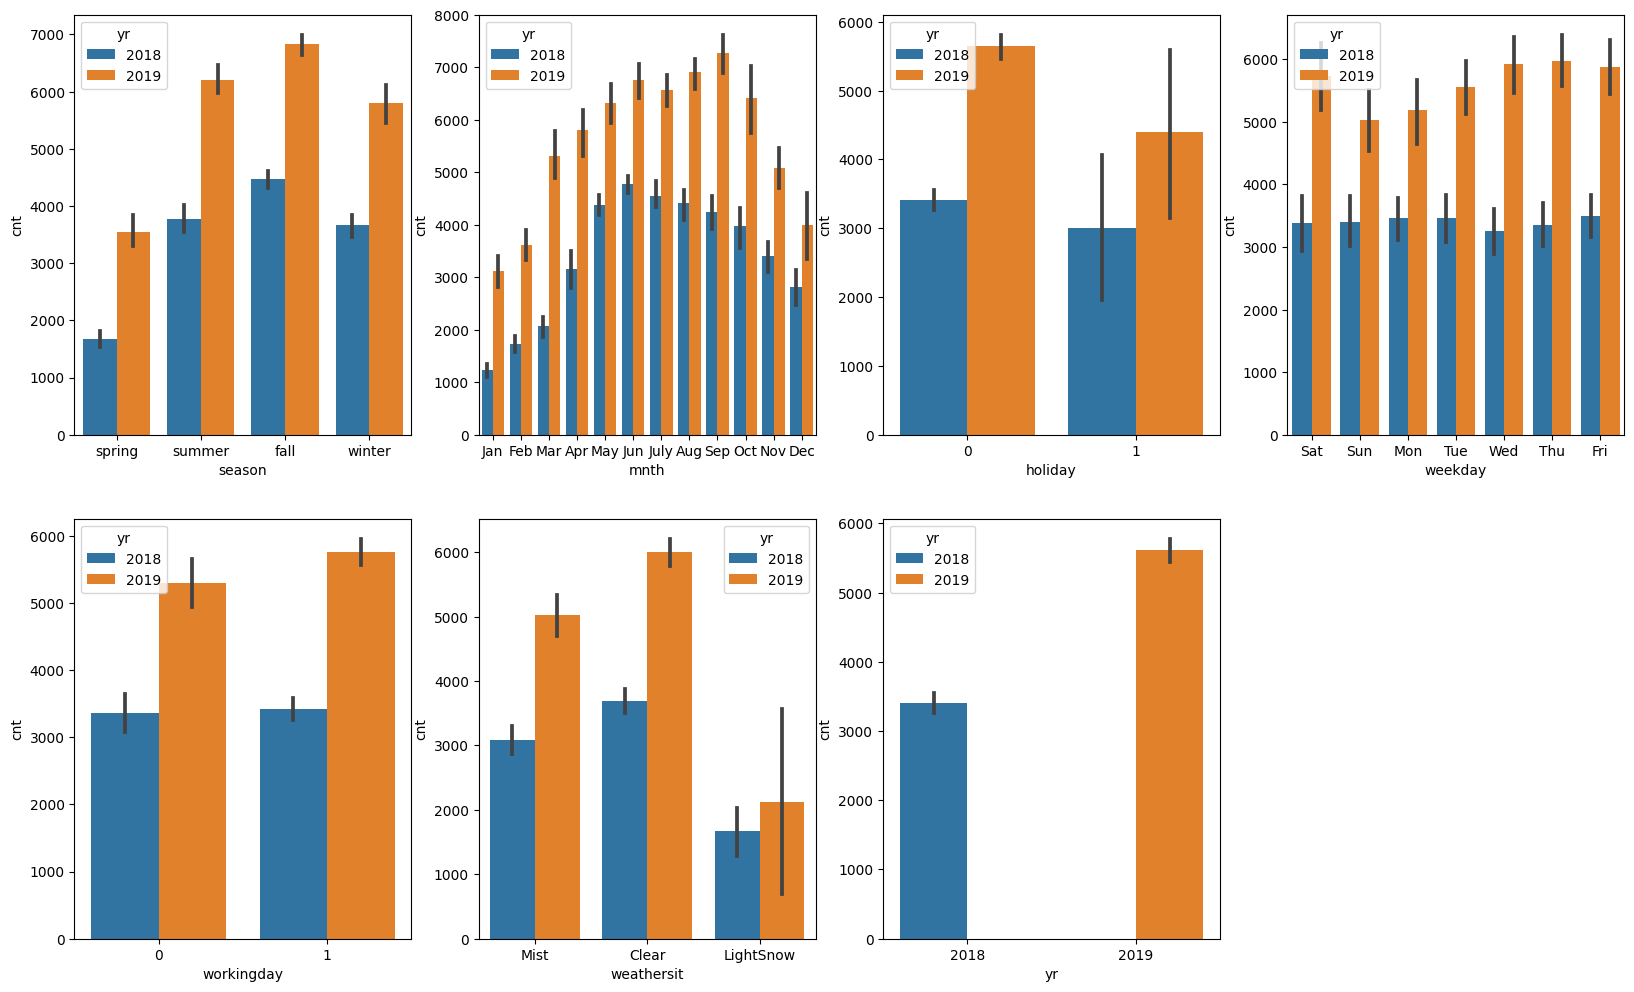

In [191]:
plt.figure(figsize= (20, 12))
cat_variables = ['season','mnth','holiday','weekday', 'workingday', 'weathersit', 'yr']
for i in range(len(cat_variables)):
    plt.subplot(2, 4, (i+1))
    sns.barplot(x = cat_variables[i], y = 'cnt', hue='yr',data=bike)
    

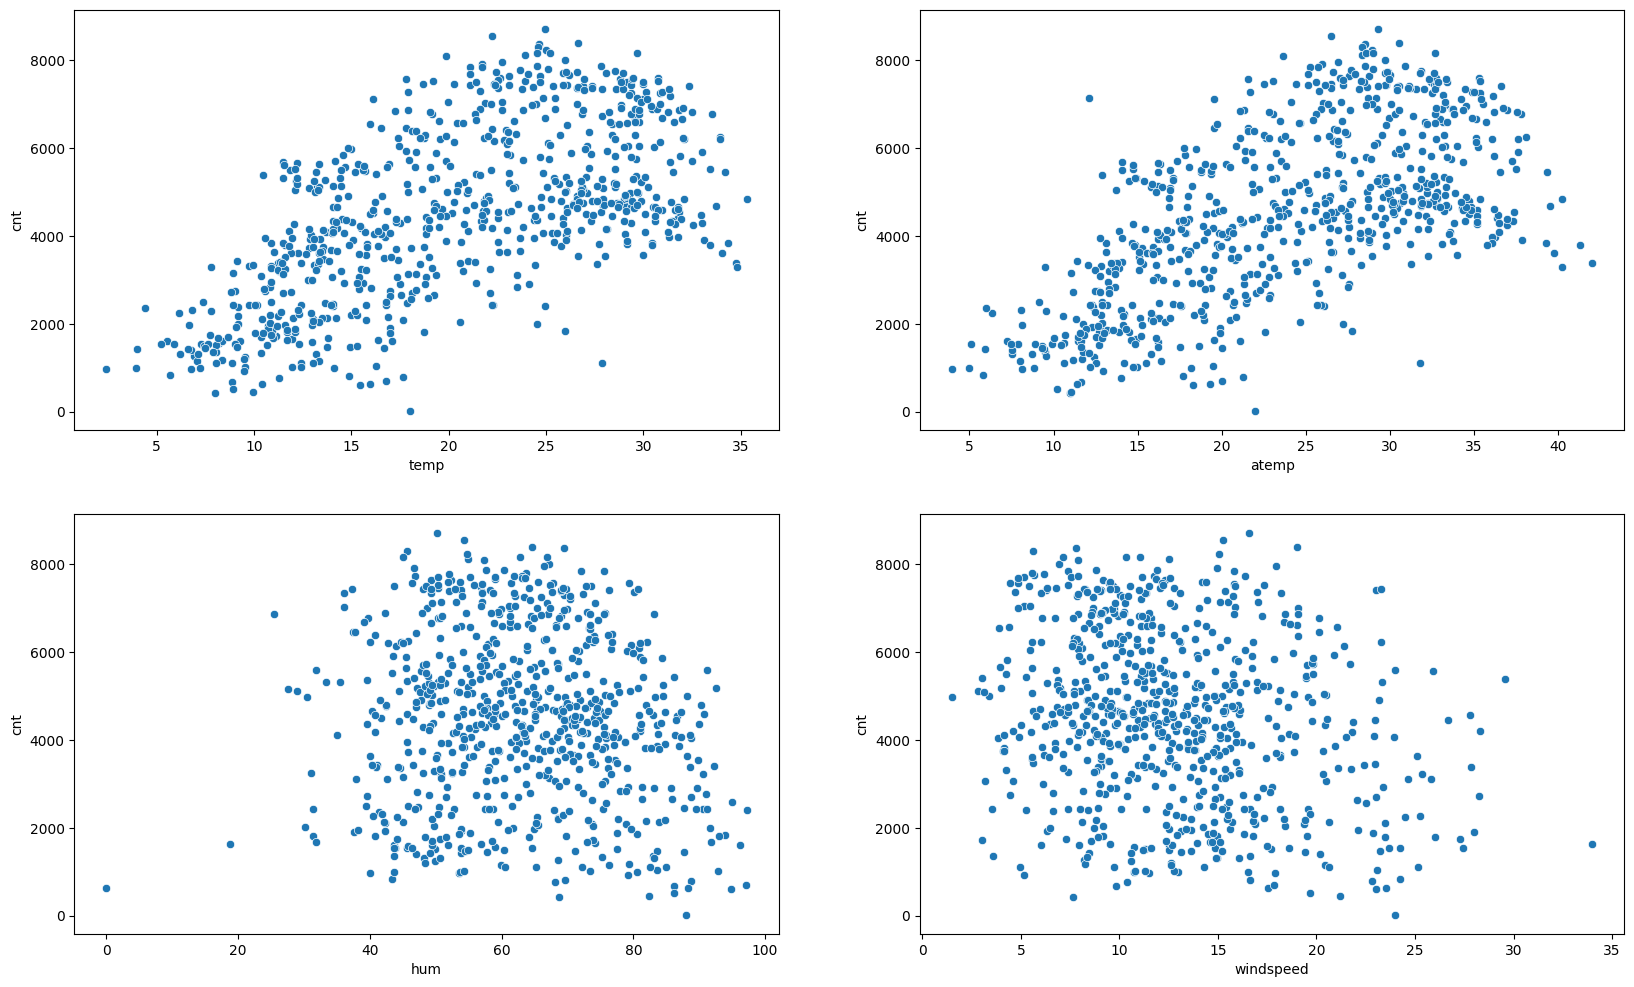

In [192]:
plt.figure(figsize= (20, 12))
numeric_col = list(numeric_columns)
# Remove target variable
target_variable = 'cnt'
numeric_col.remove(target_variable)
for i in range(len(numeric_col)):
    plt.subplot(2, 2, (i+1))
    sns.scatterplot(x = numeric_col[i], y = target_variable, data=bike)


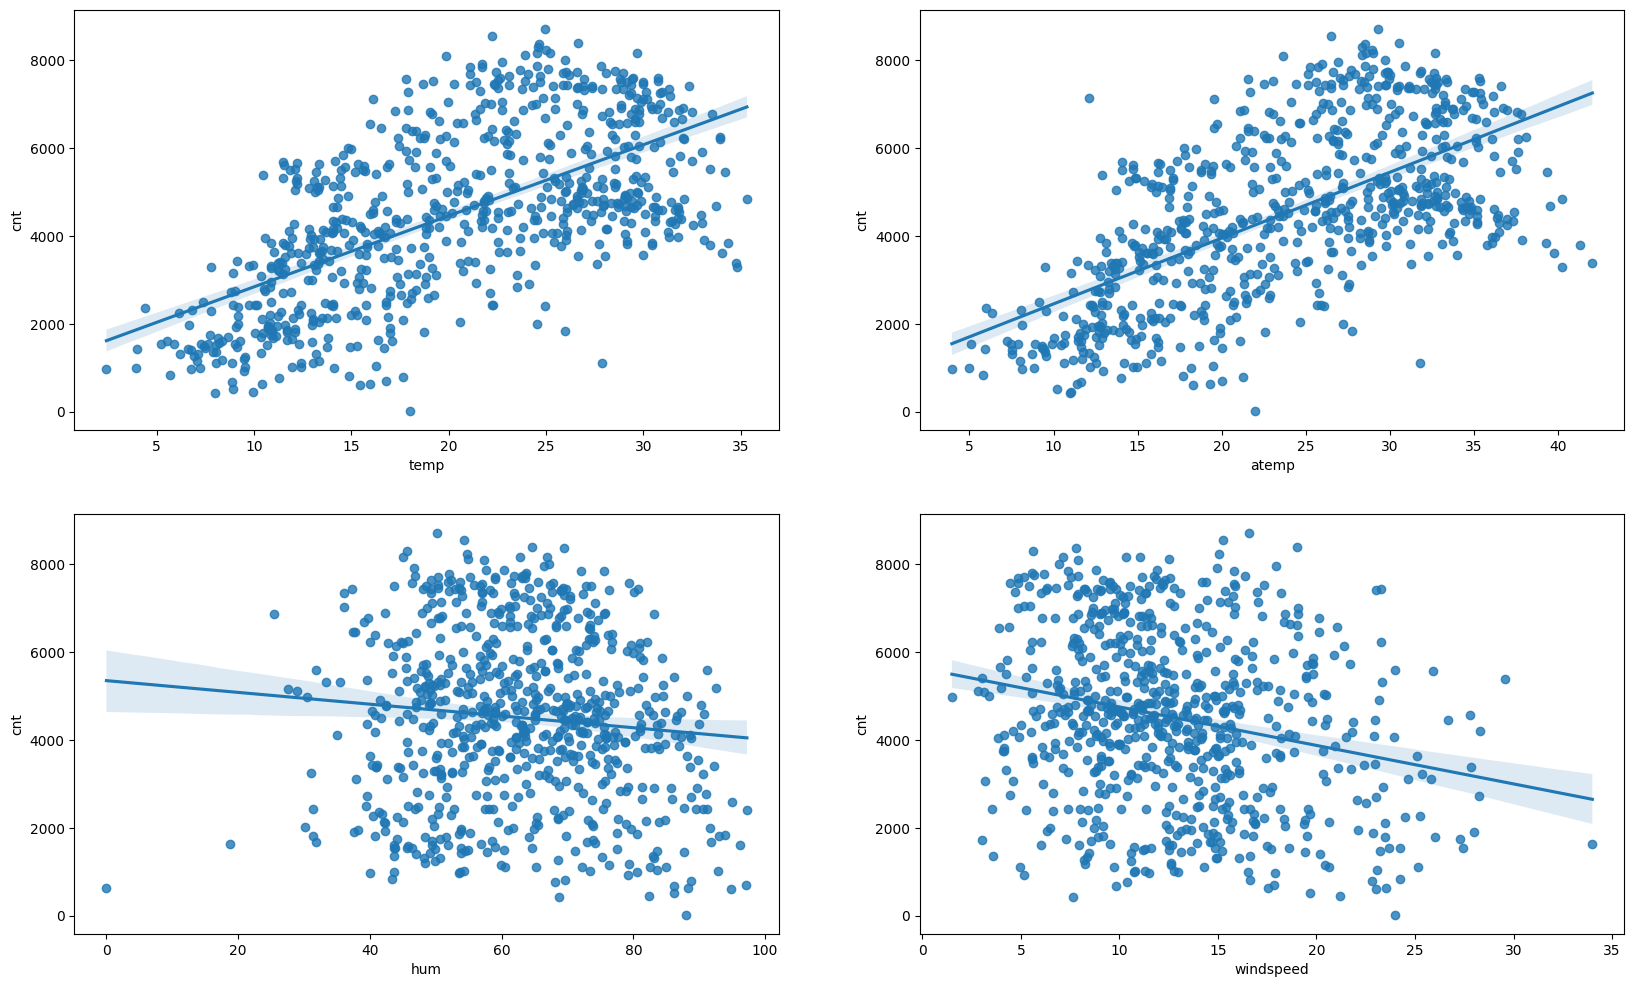

In [193]:
plt.figure(figsize= (20, 12))
for i in range(len(numeric_col)):
    plt.subplot(2, 2, (i+1))
    sns.regplot(x = numeric_col[i], y = target_variable, data=bike)

<Axes: >

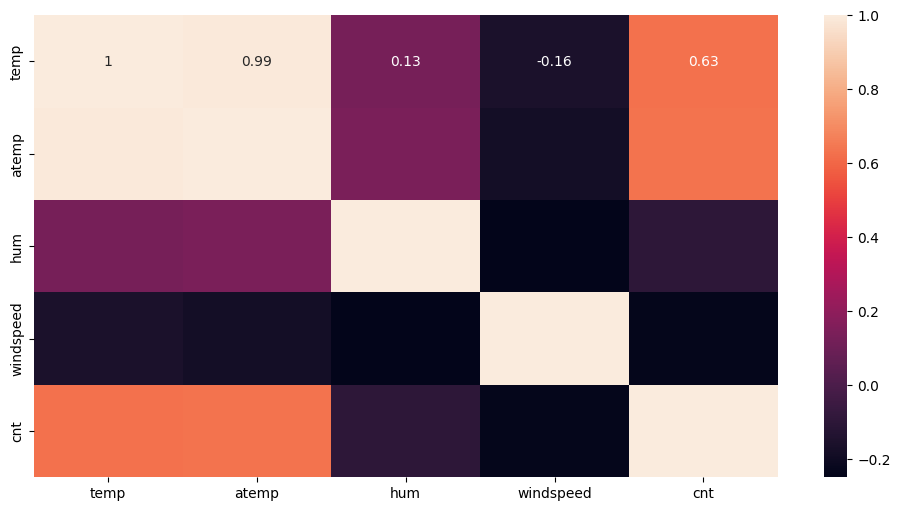

In [251]:
plt.figure(figsize=(12, 6))
num_columns_df = bike[numeric_columns]
sns.heatmap(num_columns_df.corr(numeric_only = True), annot=True)

###  Observation from above bar plots, scatter plot and reg plot
#### Bike Rentals 
- yr 2019 has more rental than yr 2018
- More in the fall season
- More in non-holidays i.e working days
- More in working days
- Not much significant difference across the weekdays
- More during clear - partial cloudy weather
- More in Jun and Sep
- with respect to years, in general 2019 shows more rentals in all categories
- It is showing good linear relationship with temp and also high positive correlation 
- Humidity and Windspeed are very much scattered

## DATA PREPARATION

### Data Encoding Steps

#### Dummy Variables Creations

Dummy related reference : https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-dummy-coding/

- Creating dummy variables out of categorial variables
- Encoding it to 0 and 1
- The above tasks can be done automatically using get_dummies method from pandas library

In [194]:
bike = pd.get_dummies(data = bike, columns = indicators, dtype=int, drop_first=True)
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   holiday               730 non-null    int64  
 1   workingday            730 non-null    int64  
 2   temp                  730 non-null    float64
 3   atemp                 730 non-null    float64
 4   hum                   730 non-null    float64
 5   windspeed             730 non-null    float64
 6   cnt                   730 non-null    int64  
 7   season_spring         730 non-null    int64  
 8   season_summer         730 non-null    int64  
 9   season_winter         730 non-null    int64  
 10  mnth_Aug              730 non-null    int64  
 11  mnth_Dec              730 non-null    int64  
 12  mnth_Feb              730 non-null    int64  
 13  mnth_Jan              730 non-null    int64  
 14  mnth_July             730 non-null    int64  
 15  mnth_Jun              7

In [195]:
bike.shape

(730, 30)

Number of Rows = 730, 
Number of columns = 30

## DATA SPLIT - TRAIN AND TEST

In [196]:
np.random.seed(0)
df_train, df_test = train_test_split(bike, train_size = 0.7, random_state = 100)

In [197]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 576 to 520
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   holiday               510 non-null    int64  
 1   workingday            510 non-null    int64  
 2   temp                  510 non-null    float64
 3   atemp                 510 non-null    float64
 4   hum                   510 non-null    float64
 5   windspeed             510 non-null    float64
 6   cnt                   510 non-null    int64  
 7   season_spring         510 non-null    int64  
 8   season_summer         510 non-null    int64  
 9   season_winter         510 non-null    int64  
 10  mnth_Aug              510 non-null    int64  
 11  mnth_Dec              510 non-null    int64  
 12  mnth_Feb              510 non-null    int64  
 13  mnth_Jan              510 non-null    int64  
 14  mnth_July             510 non-null    int64  
 15  mnth_Jun              510 

In [198]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 184 to 653
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   holiday               220 non-null    int64  
 1   workingday            220 non-null    int64  
 2   temp                  220 non-null    float64
 3   atemp                 220 non-null    float64
 4   hum                   220 non-null    float64
 5   windspeed             220 non-null    float64
 6   cnt                   220 non-null    int64  
 7   season_spring         220 non-null    int64  
 8   season_summer         220 non-null    int64  
 9   season_winter         220 non-null    int64  
 10  mnth_Aug              220 non-null    int64  
 11  mnth_Dec              220 non-null    int64  
 12  mnth_Feb              220 non-null    int64  
 13  mnth_Jan              220 non-null    int64  
 14  mnth_July             220 non-null    int64  
 15  mnth_Jun              220 

In [199]:
numeric_columns

['temp', 'atemp', 'hum', 'windspeed', 'cnt']

## RESCALING

scaling helps us for easy interpretation and faster convergence. It is important to note that scaling just affects the coefficients and none of the other parameters like t-statistic, F-statistic, p-values, R-squared, etc. 

There are two major methods to scale the variables, i.e. standardisation and MinMax scaling. Standardisation basically brings all of the data into a standard normal distribution with mean zero and standard deviation one. MinMax scaling, on the other hand, brings all of the data in the range of 0 and 1. 

Here we are going to use MinMax scaler

In [200]:
scaler = MinMaxScaler()

In [201]:
df_train[numeric_columns] = scaler.fit_transform(df_train[numeric_columns])

In [202]:
df_train.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_LightSnow,weathersit_Mist,yr_2019
576,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,1,0,0,0,1
426,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,...,0,0,1,0,0,0,0,0,1,1
728,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,1,0,0,0,0,0,1
482,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,...,0,0,1,0,0,0,0,0,1,1
111,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [203]:
y_train = df_train.pop('cnt')
X_train = df_train

## FEATURE SELECTIONS

#### Feature Elimation via RFE

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Ref : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [204]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# Running RFE

rfe = RFE(lm, n_features_to_select=15)             
rfe = rfe.fit(X_train, y_train)

In [205]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 10),
 ('mnth_Dec', False, 4),
 ('mnth_Feb', False, 5),
 ('mnth_Jan', False, 2),
 ('mnth_July', True, 1),
 ('mnth_Jun', False, 14),
 ('mnth_Mar', False, 15),
 ('mnth_May', False, 7),
 ('mnth_Nov', False, 3),
 ('mnth_Oct', False, 12),
 ('mnth_Sep', True, 1),
 ('weekday_Mon', False, 9),
 ('weekday_Sat', True, 1),
 ('weekday_Sun', True, 1),
 ('weekday_Thu', False, 11),
 ('weekday_Tue', False, 8),
 ('weekday_Wed', False, 13),
 ('weathersit_LightSnow', True, 1),
 ('weathersit_Mist', True, 1),
 ('yr_2019', True, 1)]

Columns are kept after RFE 

In [206]:
col = X_train.columns[rfe.support_]
col

Index(['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring',
       'season_summer', 'season_winter', 'mnth_July', 'mnth_Sep',
       'weekday_Sat', 'weekday_Sun', 'weathersit_LightSnow', 'weathersit_Mist',
       'yr_2019'],
      dtype='object')

In [207]:
col_removed = X_train.columns[~rfe.support_]
col_removed

Index(['atemp', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jun',
       'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'weekday_Mon',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed'],
      dtype='object')

In [208]:
# Taking only RFEd columns further 

X_train_rfe = X_train[col]
X_train_rfe.head()

,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_July,mnth_Sep,weekday_Sat,weekday_Sun,weathersit_LightSnow,weathersit_Mist,yr_2019
576,0,1,0.815169,0.725633,0.264686,0,0,0,1,0,0,0,0,0,1
426,0,0,0.442393,0.640189,0.255342,1,0,0,0,0,1,0,0,1,1
728,0,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,1,0,0,1
482,0,0,0.395666,0.504508,0.188475,0,1,0,0,0,1,0,0,1,1
111,0,1,0.345824,0.751824,0.380981,0,1,0,0,0,0,0,0,1,0


In [209]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
def calculate_vif(X_train_rfe):
    vif = pd.DataFrame()
    vif['Features'] = X_train_rfe.columns
    vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

# Modelling is kept as a seperate method so that it can be used again and again based on vif 

def modelling(X_train_rfe):

    # Here, OLS stands for Ordinary Least Squares, which is the method that 'statsmodels' use to fit the line. 
    # we use the command 'add_constant' so that statsmodels also fits an intercept. 
    # If we don't use this command, it will fit a line passing through the origin by default.
    
    X_train_rfe_lm = sm.add_constant(X_train_rfe)
    lm = sm.OLS(y_train, X_train_rfe_lm).fit()
    return X_train_rfe_lm, X_train_rfe, lm

In [210]:
X_train_rfe

,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_July,mnth_Sep,weekday_Sat,weekday_Sun,weathersit_LightSnow,weathersit_Mist,yr_2019
576,0,1,0.815169,0.725633,0.264686,0,0,0,1,0,0,0,0,0,1
426,0,0,0.442393,0.640189,0.255342,1,0,0,0,0,1,0,0,1,1
728,0,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,1,0,0,1
482,0,0,0.395666,0.504508,0.188475,0,1,0,0,0,1,0,0,1,1
111,0,1,0.345824,0.751824,0.380981,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,1,0.863973,0.679690,0.187140,0,0,0,0,0,0,0,0,0,1
53,0,1,0.202618,0.435939,0.111379,1,0,0,0,0,0,0,0,0,0
350,0,0,0.248216,0.577930,0.431816,0,0,1,0,0,1,0,0,1,0
79,0,1,0.462664,0.759870,0.529881,0,1,0,0,0,0,0,0,1,0


### MODELLING 

#### Manual steps

- Build the model 
- Drop the features that are least helpful in prediction (high p-value)
- Drop the features that are redundant (using correlations and VIF)
- Rebuild model and repeat

### Linear Model 1

In [211]:
X_train_rfe_lm, X_train_rfe, lm = modelling(X_train_rfe)

In [212]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          2.11e-191
Time:                        15:16:18   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1995      0.028      7.200      0.000       0.145       0.254
holiday                 -0.0184      0.021     -0.867      0.386      -0.060       0.023
workingday               0.0837      0.010      8.665      0.000       0.065       0.103
temp                     0.5277      0.033     15.884      0.000       0.462       0.593
hum                     -0.1611      0.037     -4.313      0.000      -0.234      -0.088
windspeed               -0.1809      0.025     -7.118      0.000      -0.231      -0.131
season_spring           -0.0555      0.021     -2.698      0.007      -0.096      -0.015
season_summer            0.0537      0.015      3.631      0.000       0.025       0.083
season_winter            0.0992      0.017      5.815      0.000       0.066       0.133
mnth_July               -0.0546      0.018     -3.019      0.003      -0.090      -0.019
mnth_Sep                 0.0820      0.017      4.966      0.000       0.050       0.114
weekday_Sat              0.0937      0.012      8.040      0.000       0.071       0.117
weekday_Sun              0.0406      0.012      3.315      0.001       0.017       0.065
weathersit_LightSnow    -0.2450      0.026     -9.395      0.000      -0.296      -0.194
weathersit_Mist         -0.0563      0.010     -5.425      0.000      -0.077      -0.036
yr_2019                  0.2298      0.008     28.647      0.000       0.214       0.246
==============================================================================
Omnibus:                       64.769   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.630
Skew:                          -0.663   Prob(JB):                     9.73e-35
Kurtosis:                       5.369   Cond. No.                     6.80e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.27e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [213]:
vif = calculate_vif(X_train_rfe)
vif

,Features,VIF
1,workingday,50.68
10,weekday_Sat,12.20
11,weekday_Sun,11.79
5,season_spring,5.02
2,temp,3.62
7,season_winter,3.49
0,holiday,2.91
6,season_summer,2.62
3,hum,1.91
13,weathersit_Mist,1.57


### Linear Model 2

Since the 'holiday' has higher p-value we are dropping the indicator

In [214]:
X_train_rfe_m1 = X_train_rfe.drop(["holiday"], axis = 1)
X_train_rfe_m1_lm, X_train_rfe_m1, lm = modelling(X_train_rfe_m1)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          2.11e-191
Time:                        15:16:18   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1811      0.042      4.301      0.000       0.098       0.264
workingday               0.1021      0.025      4.024      0.000       0.052       0.152
temp                     0.5277      0.033     15.884      0.000       0.462       0.593
hum                     -0.1611      0.037     -4.313      0.000      -0.234      -0.088
windspeed               -0.1809      0.025     -7.118      0.000      -0.231      -0.131
season_spring           -0.0555      0.021     -2.698      0.007      -0.096      -0.015
season_summer            0.0537      0.015      3.631      0.000       0.025       0.083
season_winter            0.0992      0.017      5.815      0.000       0.066       0.133
mnth_July               -0.0546      0.018     -3.019      0.003      -0.090      -0.019
mnth_Sep                 0.0820      0.017      4.966      0.000       0.050       0.114
weekday_Sat              0.1121      0.027      4.181      0.000       0.059       0.165
weekday_Sun              0.0591      0.027      2.192      0.029       0.006       0.112
weathersit_LightSnow    -0.2450      0.026     -9.395      0.000      -0.296      -0.194
weathersit_Mist         -0.0563      0.010     -5.425      0.000      -0.077      -0.036
yr_2019                  0.2298      0.008     28.647      0.000       0.214       0.246
==============================================================================
Omnibus:                       64.769   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.630
Skew:                          -0.663   Prob(JB):                     9.73e-35
Kurtosis:                       5.369   Cond. No.                         25.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After dropping 'holiday' no change in R2 values which shows it is very much insignificant, but VIF of 'hum' increases high

In [215]:
vif = calculate_vif(X_train_rfe_m1)
vif

,Features,VIF
2,hum,32.10
1,temp,18.99
0,workingday,18.41
3,windspeed,4.91
9,weekday_Sat,4.91
4,season_spring,4.80
10,weekday_Sun,4.76
6,season_winter,3.69
5,season_summer,3.04
12,weathersit_Mist,2.31


### Linear Model 3

Since 'hum' has higher vif we are dropping the indicator

In [216]:
X_train_rfe_m2 = X_train_rfe_m1.drop(["hum"], axis = 1)
X_train_rfe_m2_lm, X_train_rfe_m2, lm = modelling(X_train_rfe_m2)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.2
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          1.28e-188
Time:                        15:16:18   Log-Likelihood:                 508.20
No. Observations:                 510   AIC:                            -988.4
Df Residuals:                     496   BIC:                            -929.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1008      0.038      2.624      0.009       0.025       0.176
workingday               0.1029      0.026      3.983      0.000       0.052       0.154
temp                     0.4915      0.033     15.027      0.000       0.427       0.556
windspeed               -0.1491      0.025     -6.024      0.000      -0.198      -0.100
season_spring           -0.0655      0.021     -3.147      0.002      -0.106      -0.025
season_summer            0.0477      0.015      3.180      0.002       0.018       0.077
season_winter            0.0846      0.017      4.971      0.000       0.051       0.118
mnth_July               -0.0496      0.018     -2.702      0.007      -0.086      -0.014
mnth_Sep                 0.0759      0.017      4.537      0.000       0.043       0.109
weekday_Sat              0.1146      0.027      4.201      0.000       0.061       0.168
weekday_Sun              0.0567      0.027      2.069      0.039       0.003       0.111
weathersit_LightSnow    -0.2895      0.024    -11.880      0.000      -0.337      -0.242
weathersit_Mist         -0.0822      0.009     -9.514      0.000      -0.099      -0.065
yr_2019                  0.2337      0.008     28.828      0.000       0.218       0.250
==============================================================================
Omnibus:                       66.828   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.148
Skew:                          -0.682   Prob(JB):                     6.17e-36
Kurtosis:                       5.402   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After dropping 'hum' there is an increase in p-value for weekday_Sun, so next we need to drop weeday_Sun

In [217]:
vif = calculate_vif(X_train_rfe_m2)
vif

,Features,VIF
0,workingday,16.19
1,temp,12.74
2,windspeed,4.76
8,weekday_Sat,4.45
9,weekday_Sun,4.21
3,season_spring,3.82
5,season_winter,2.78
4,season_summer,2.76
12,yr_2019,2.07
6,mnth_July,1.60


### Linear Model 4

Since 'weekday_Sun' p-value got increased in the previous model, so dropping

In [218]:
X_train_rfe_m3 = X_train_rfe_m2.drop(["weekday_Sun"], axis = 1)
X_train_rfe_m3_lm, X_train_rfe_m3, lm = modelling(X_train_rfe_m3)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.2
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          7.12e-189
Time:                        15:16:18   Log-Likelihood:                 506.01
No. Observations:                 510   AIC:                            -986.0
Df Residuals:                     497   BIC:                            -931.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1492      0.031      4.881      0.000       0.089       0.209
workingday               0.0545      0.011      4.938      0.000       0.033       0.076
temp                     0.4920      0.033     14.991      0.000       0.427       0.556
windspeed               -0.1499      0.025     -6.040      0.000      -0.199      -0.101
season_spring           -0.0664      0.021     -3.182      0.002      -0.107      -0.025
season_summer            0.0481      0.015      3.196      0.001       0.019       0.078
season_winter            0.0838      0.017      4.910      0.000       0.050       0.117
mnth_July               -0.0486      0.018     -2.637      0.009      -0.085      -0.012
mnth_Sep                 0.0740      0.017      4.414      0.000       0.041       0.107
weekday_Sat              0.0664      0.014      4.671      0.000       0.038       0.094
weathersit_LightSnow    -0.2883      0.024    -11.795      0.000      -0.336      -0.240
weathersit_Mist         -0.0817      0.009     -9.428      0.000      -0.099      -0.065
yr_2019                  0.2339      0.008     28.756      0.000       0.218       0.250
==============================================================================
Omnibus:                       72.429   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.537
Skew:                          -0.721   Prob(JB):                     1.40e-40
Kurtosis:                       5.560   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [219]:
vif = calculate_vif(X_train_rfe_m3)
vif

,Features,VIF
1,temp,6.73
0,workingday,4.66
2,windspeed,4.64
3,season_spring,2.38
4,season_summer,2.32
11,yr_2019,2.07
5,season_winter,1.91
8,weekday_Sat,1.83
6,mnth_July,1.58
10,weathersit_Mist,1.57


Temp has higher VIF but if we drop temp, it is dropping R2 significantly and also in the variate analysis we have seen temp has good relation with target variable so it is not recommended to drop temp indicator, so next option is to drop mnth_July which has relatively higher p-value

### Linear Model 5

In [220]:
X_train_rfe_m4 = X_train_rfe_m3.drop(["mnth_July"], axis = 1)
X_train_rfe_m4_lm, X_train_rfe_m4, lm = modelling(X_train_rfe_m4)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     233.6
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          1.42e-188
Time:                        15:16:18   Log-Likelihood:                 502.47
No. Observations:                 510   AIC:                            -980.9
Df Residuals:                     498   BIC:                            -930.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1406      0.031      4.597      0.000       0.080       0.201
workingday               0.0555      0.011      4.996      0.000       0.034       0.077
temp                     0.4796      0.033     14.678      0.000       0.415       0.544
windspeed               -0.1500      0.025     -6.007      0.000      -0.199      -0.101
season_spring           -0.0554      0.021     -2.692      0.007      -0.096      -0.015
season_summer            0.0626      0.014      4.447      0.000       0.035       0.090
season_winter            0.0958      0.017      5.788      0.000       0.063       0.128
mnth_Sep                 0.0873      0.016      5.423      0.000       0.056       0.119
weekday_Sat              0.0667      0.014      4.665      0.000       0.039       0.095
weathersit_LightSnow    -0.2893      0.025    -11.765      0.000      -0.338      -0.241
weathersit_Mist         -0.0804      0.009     -9.241      0.000      -0.097      -0.063
yr_2019                  0.2344      0.008     28.655      0.000       0.218       0.250
==============================================================================
Omnibus:                       76.073   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.745
Skew:                          -0.765   Prob(JB):                     1.71e-41
Kurtosis:                       5.548   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [221]:
vif = calculate_vif(X_train_rfe_m4)
vif

,Features,VIF
1,temp,5.48
0,workingday,4.66
2,windspeed,4.64
3,season_spring,2.30
10,yr_2019,2.07
4,season_summer,2.00
7,weekday_Sat,1.83
5,season_winter,1.76
9,weathersit_Mist,1.57
6,mnth_Sep,1.23


### Linear Model 6

After dropping "mnth_July", I tried with other indicators for best fit for train and test, removal of 'windspeed' gives the better result with respect to R2 for train and Test so I am removing

In [222]:
X_train_rfe_m5 = X_train_rfe_m4.drop(["windspeed"], axis = 1)
X_train_rfe_m5_lm, X_train_rfe_m5, lm = modelling(X_train_rfe_m5)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     236.7
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          3.10e-182
Time:                        15:16:18   Log-Likelihood:                 484.63
No. Observations:                 510   AIC:                            -947.3
Df Residuals:                     499   BIC:                            -900.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0902      0.030      2.964      0.003       0.030       0.150
workingday               0.0566      0.011      4.924      0.000       0.034       0.079
temp                     0.4914      0.034     14.564      0.000       0.425       0.558
season_spring           -0.0650      0.021     -3.060      0.002      -0.107      -0.023
season_summer            0.0527      0.014      3.642      0.000       0.024       0.081
season_winter            0.0970      0.017      5.666      0.000       0.063       0.131
mnth_Sep                 0.0916      0.017      5.508      0.000       0.059       0.124
weekday_Sat              0.0645      0.015      4.365      0.000       0.035       0.094
weathersit_LightSnow    -0.3041      0.025    -12.017      0.000      -0.354      -0.254
weathersit_Mist         -0.0786      0.009     -8.743      0.000      -0.096      -0.061
yr_2019                  0.2334      0.008     27.580      0.000       0.217       0.250
==============================================================================
Omnibus:                       77.597   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.504
Skew:                          -0.754   Prob(JB):                     1.44e-45
Kurtosis:                       5.728   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [223]:
vif = calculate_vif(X_train_rfe_m5)
vif

,Features,VIF
1,temp,4.72
0,workingday,4.63
9,yr_2019,2.07
6,weekday_Sat,1.81
3,season_summer,1.75
2,season_spring,1.70
4,season_winter,1.59
8,weathersit_Mist,1.57
5,mnth_Sep,1.23
7,weathersit_LightSnow,1.07


In [224]:
lm.params

const                   0.090189
workingday              0.056551
temp                    0.491382
season_spring          -0.064952
season_summer           0.052659
season_winter           0.096999
mnth_Sep                0.091602
weekday_Sat             0.064533
weathersit_LightSnow   -0.304122
weathersit_Mist        -0.078644
yr_2019                 0.233358
dtype: float64

With this we have very have all the indicators with less VIF (i.e 5) and less or zero p-values. 
We will proceed with this model for further analysis and validating the test data

In [225]:
X_train_rfe_m5.columns

Index(['workingday', 'temp', 'season_spring', 'season_summer', 'season_winter',
       'mnth_Sep', 'weekday_Sat', 'weathersit_LightSnow', 'weathersit_Mist',
       'yr_2019'],
      dtype='object')

### Residual Analysis

In [226]:
y_pred_train = lm.predict(X_train_rfe_m5_lm)

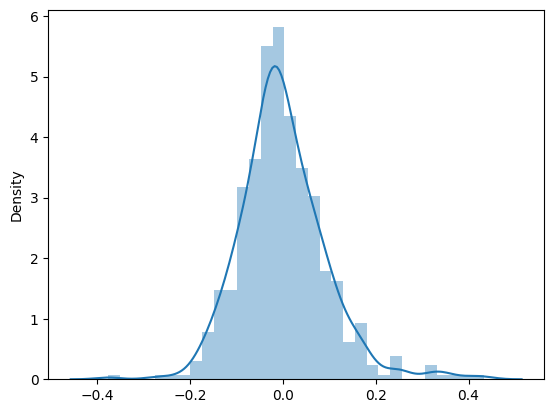

-4.4321844669349387e-16


In [227]:
res = y_pred_train - y_train
sns.distplot(res)
plt.show()
print(res.mean())

The above plot is normaly distributed and the mean is centered around zero almost

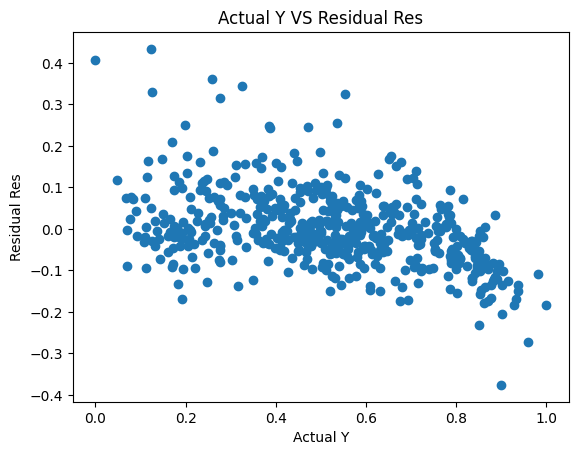

In [228]:
scatterPlot = plt.scatter(x = y_train, y = res)
plt.title('Actual Y VS Residual Res')
plt.xlabel('Actual Y')
plt.ylabel('Residual Res')
plt.show()

<Axes: xlabel='cnt'>

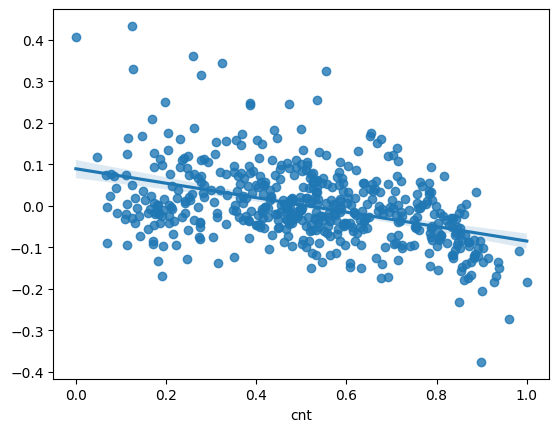

In [248]:
sns.regplot(x = y_train, y = res)

There is no pattern as per say for errors from the above plot

Residual Analysis Observation
- Error plot is appeared to be normally distributed and No evidence for pattern in the error
- Mean is centered around zero 

In [229]:
numeric_columns

['temp', 'atemp', 'hum', 'windspeed', 'cnt']

### Test Data Prediction and Analysis

In [230]:
df_test[numeric_columns] = scaler.transform(df_test[numeric_columns])
df_test.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_LightSnow,weathersit_Mist,yr_2019
184,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,0,...,0,1,0,0,0,0,0,0,1,0
535,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,0,...,0,0,0,0,0,0,1,0,0,1
299,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,1,...,0,0,0,0,1,0,0,0,1,0
221,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,0,...,0,0,0,0,0,0,1,0,0,0
152,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [231]:
df_test.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_LightSnow,weathersit_Mist,yr_2019
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,...,0.086364,0.127273,0.118182,0.145455,0.163636,0.168182,0.100000,0.027273,0.318182,0.481818
std,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,...,0.281541,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684,0.163248,0.466833,0.500809
min,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [232]:
y_test = df_test.pop('cnt')
X_test = df_test[X_train_rfe_m5.columns]

In [233]:
X_test_sm = sm.add_constant(X_test)
X_test_sm

,const,workingday,temp,season_spring,season_summer,season_winter,mnth_Sep,weekday_Sat,weathersit_LightSnow,weathersit_Mist,yr_2019
184,1.0,0,0.831783,0,0,0,0,0,0,1,0
535,1.0,1,0.901354,0,1,0,0,0,0,0,1
299,1.0,1,0.511964,0,0,1,0,0,0,1,0
221,1.0,1,0.881625,0,0,0,0,0,0,0,0
152,1.0,1,0.817246,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
702,1.0,1,0.519232,0,0,1,0,0,0,0,1
127,1.0,0,0.584649,0,1,0,0,0,0,0,0
640,1.0,1,0.745598,0,0,1,0,0,0,1,1
72,1.0,1,0.331557,1,0,0,0,0,0,0,0


In [234]:
y_test_pred = lm.predict(X_test_sm)

### Q-Q plot

In statistics, a Q–Q plot (quantile-quantile plot) is a probability plot, a graphical method for comparing two probability distributions by plotting their quantiles against each other

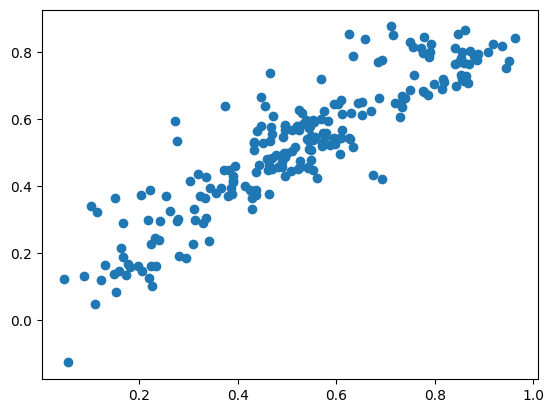

In [235]:
plt.scatter(y_test, y_test_pred)
plt.show()

<Axes: xlabel='cnt'>

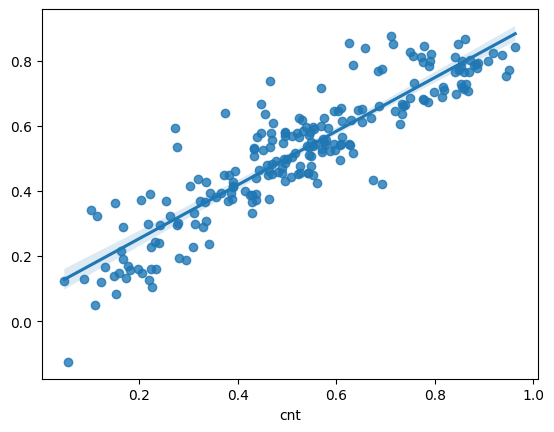

In [245]:
sns.regplot(x = y_test, y = y_test_pred)

Since the plot looks linear so we can interpret that both data sets (test and train) have come from the same data sets i.e same distribution

### CALCULATING TEST R-SQUARE BASED ON THE PREDICTION

In [236]:
round(r2_score(y_test, y_test_pred),3)

0.812

Train R-Square is 0.826 and Test R-Square is 0.812, i.e 1.7% difference only compared to the trained R-Square, so it is a good model since it is less than 5% 

In [237]:
lm.params

const                   0.090189
workingday              0.056551
temp                    0.491382
season_spring          -0.064952
season_summer           0.052659
season_winter           0.096999
mnth_Sep                0.091602
weekday_Sat             0.064533
weathersit_LightSnow   -0.304122
weathersit_Mist        -0.078644
yr_2019                 0.233358
dtype: float64

In [238]:
params = lm.params

In [239]:
for i in params:
    print(i)

0.09018946479463985
0.05655098466478662
0.49138208205871964
-0.0649519728596351
0.0526589352706324
0.09699859222848603
0.09160192479110228
0.06453309052042189
-0.3041218350093764
-0.07864429909673093
0.23335780766689712


In [240]:
Equation_Formation = 'y = '

In [241]:
for i in params.index:
    Equation_Formation = Equation_Formation + " (" + "{:.4f}".format(params[i]) + ") x " + i + " +"

In [242]:
Equation_Formation = Equation_Formation[:len(Equation_Formation) - 2]

In [243]:
Equation_Formation

'y =  (0.0902) x const + (0.0566) x workingday + (0.4914) x temp + (-0.0650) x season_spring + (0.0527) x season_summer + (0.0970) x season_winter + (0.0916) x mnth_Sep + (0.0645) x weekday_Sat + (-0.3041) x weathersit_LightSnow + (-0.0786) x weathersit_Mist + (0.2334) x yr_2019'

## RESULT

|          | Score |
| -------- | ------- |
| Train Data R-Square  | 0.826   |
| Train Data Adjusted R-Square |    0.822  |
| Test Data R-Square    | 0.812    |

|                     |  Coefficient|
----------------------|------------
|const                |   0.090189 |
|workingday           |   0.056551 |
|temp                 |   0.491382 |
|season_spring        |  -0.064952 |
|season_summer        |   0.052659 |
|season_winter        |   0.096999 |
|mnth_Sep             |   0.091602 |
|weekday_Sat          |   0.064533 |
|weathersit_LightSnow |  -0.304122 |
|weathersit_Mist      |  -0.078644 |
|yr_2019              |   0.233358 |

### Final Model 

#### **y** =  **(0.0902)** x *const* + **(0.0566)** x *workingday* + **(0.4914)** x *temp* + **(-0.0650)** x *season_spring* + **(0.0527)** x *season_summer* + **(0.0970)** x *season_winter* + **(0.0916)** x *mnth_Sep* + **(0.0645)** x *weekday_Sat* + **(-0.3041)** x *weathersit_LightSnow* + **(-0.0786)** x *weathersit_Mist* + **(0.2334)** x *yr_2019*

#### MAJOR CONCLUSION FROM THE MODEL

- temp indicator is a prime factor
- 2019 yr has more rental than 2018
- impact of winter season is more
- If it is a light snow/ light rain time the demand goes down